In [52]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot
pd.set_option('display.max_rows', None)

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    matplotlib.pyplot.scatter(df.iloc[row_num,:], time)
    
def dist(x, y):
    # TODO normed difference
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 300):


    centroids = pd[np.random.choice(pd.shape[0], K)]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
    return C, centroids

   
      


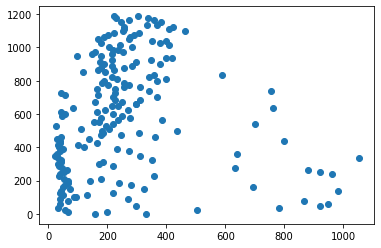

In [53]:
s745_df = get_normed_and_zero_filtered_data("data/sub_0745_miRNA.ec.tab")
s745_time = get_s745_time(s745_df.columns)
s814_df = get_normed_and_zero_filtered_data("data/sub_0814_miRNA.ec.tab")

plot_one_row_scatter(s745_df, 1,s745_time )


In [54]:


s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)

sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )

#print(s814_adata.var[s814_adata.var.highly_variable == True])





s814_pd = get_periodgram(s814_adata[:,s814_adata.var.highly_variable]) 
s814_pd_array = np.array([i[1] for i in s814_pd])
np_array =np.array(s814_pd)
#print(np_array.shape)
#print(s814_pd_array.shape)



In [55]:
K = 6
C, centroids = k_means_from_pd_data(s814_pd_array,K)

print('C = \n', C)

C = 
 [2 3 0 1 1 0 0 2 5 2 2 3 0 4 3 5 2 2 2 0 3 4 4 4 5 5 1 2 3 3 2 5 1 5 3 2 0
 5 3 3 0 2 5 2 2 2 4 2 0 2 4 4 3 4 4 2 3 5 2 2 4 2 4 2 4 2 5 2 3 4 4 0 2 3
 2 2 0 5 1 4 2 5 1 1 5 2 1 5 5 5 5 2 4 1 5 2 1 2 3 5]


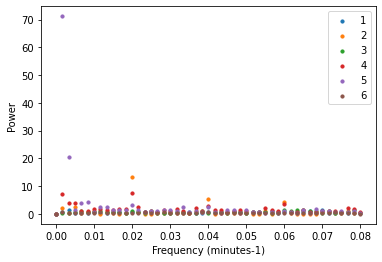

0.01

In [22]:
import matplotlib.pyplot as plt
#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


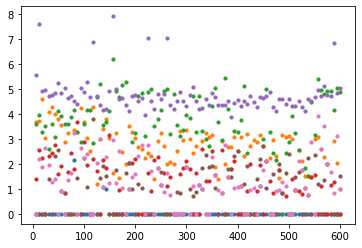

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


for i in range(len(C)):
    if C[i]==3:
        y = s814_adata[:,s814_adata.var.highly_variable][:,i]
        ax1.scatter(y.obs.time,y.X, s=10)
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))